# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Implementing Time Invariant Portfolio Protection (TIPP)

An issue with CPPI is that once the portfolio reaches a certain new high over time, the expectation of it going back below the floor price reduces considerably. Therefore, the portfolio will comprise entirely of the risky asset. In this case, one would want to update the floor price to a higher level, dependent on the previous maximum portfolio value.

With TIPP, we update the floor value relative to the previous peak of the portfolio.

In this notebook, you will perform the following steps:

1. [Read the Data](#read)
2. [Setting Portfolio Value, Multiplier Value, Floor Value](#portfolio_val)
3. [Update the CPPI Code for Increasing Floor Value](#strategy_logic)
4. [Portion of Capital](#portion)
5. [Leverage Ratio](#leverage)


## Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Quantra function to analyse the performance
import sys
sys.path.append("..")
from data_modules.position_sizing_quantra import performance_analysis, plot_leverage, plot_portion_of_capital

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

<a id='read'></a>
## Read the Data

The index reversal strategy's trading signal, returns and portfolio value are read from a file named `strategy_data.csv`.

In [2]:
# Read the signal and cumulative returns of the index reversal strategy
strategy_df = pd.read_csv('../data_modules/strategy_data.csv',
                          index_col=0, parse_dates=True)

strategy_df.head()

,signal,returns,cumulative_returns
2005-01-03,0,-0.000000,1.000000
2005-01-04,1,-0.000000,1.000000
2005-01-05,1,-0.003537,0.996463
2005-01-06,0,0.003296,0.999747
2005-01-07,0,-0.000000,0.999747


<a id='portfolio_val'></a>
## Setting Portfolio Value, Multiplier Value, Floor Value

1. We will define the initial portfolio value as $$ \text{Initial portfolio value = 10000}$$
2. We will define the multiplier $$\text{Multiplier = 4}$$ Multiplier can be defined as a function of past drawdowns of the index returns. So, if index has shown a drawdown of 25%, we use $$Multiplier = \frac{1}{Drawdown}$$
3. We set a floor percentage level, $$\text{Floor percent = 0.75}$$

In [3]:
# Setting initial portfolio value
initial_portfolio_value = 10000

# Setting multiplier value
m = 4

# Setting floor falue
floor_percent = 0.75

print("Initial portfolio value: ", initial_portfolio_value)
print("Multiplier value: ", m)
print("Floor percentage: ", floor_percent * 100, "%")

Initial portfolio value:  10000
Multiplier value:  4
Floor percentage:  75.0 %


<a id='strategy_logic'></a>
## Update the CPPI Code for Increasing Floor Value

The following steps are used for the TIPP Logic:
1. Initial steps from CPPI implementation of defining the cushion percentage, calculating initial cushion and floor values, initial levered returns, and the initial account value remain the same.
2. Update the floor value if the current account value is greater than the previous maximum account value as <span style="color:red">$$\text{New floor value = Floor percentage * New account high value}$$</span>
3. Update maximum account value if current account value is greater than the previous maximum account value. Update account value as $$\text{Account value = New floor value + Cushion value * (1 + Levered return)}$$
4. Update cushion value as $$\text{Cushion = Account value - Floor value}$$

In [4]:
def run_tipp(risky_r, m, initial_capital, floor_percent, signals):
    # Set up TIPP parameters
    cushion_percentage = 1 - floor_percent

    # Absolute values
    floor = floor_percent * initial_capital
    cushion = cushion_percentage * initial_capital

    # Create dataframes for intermediate values
    account_history = pd.DataFrame([np.nan for _ in range(
        len(risky_r.index))], index=risky_r.index, columns=['account_history'])
    leverage_history = pd.DataFrame([np.nan for _ in range(
        len(risky_r.index))], index=risky_r.index, columns=['leverage_history'])
    capital_used = pd.DataFrame([np.nan for _ in range(
        len(risky_r.index))], index=risky_r.index, columns=['capital_used'])

    # Intialise variables
    account_value = initial_capital
    max_account_value = initial_capital
    cap_used = 0

    # Run TIPP
    for row in range(len(risky_r)):
        # The risky asset returns will be multiplied by `m`
        levered_return = m * risky_r.iloc[row]

        # Update account value and append to DF
        account_value = floor + (cushion * (1 + levered_return))

        # Check if account_value exceeds max_account_value
        if (account_value > max_account_value):
            # If current account value > max account value, recalculate floor
            floor = floor_percent * account_value

            # Update max_account_value
            max_account_value = account_value
        account_history["account_history"].iloc[row] = account_value

        # Recalculate cushion
        cushion = account_value - floor

        # Update leverage and append to DF
        leverage = m * (cushion / account_value)
        leverage_history["leverage_history"].iloc[row] = leverage

        # Calculate capital used and append to DF
        cap_used = leverage * account_value
        capital_used["capital_used"].iloc[row] = cap_used
    
    # Update leverage and capital based on signals only for trading days
    leverage_history["leverage_history"] = leverage_history["leverage_history"] * \
        signals
    capital_used["capital_used"] = capital_used["capital_used"] * \
        signals

    return {
        'account_history': account_history,
        'leverage_history': leverage_history,
        'capital_used': capital_used
    }

##### Run the strategy 

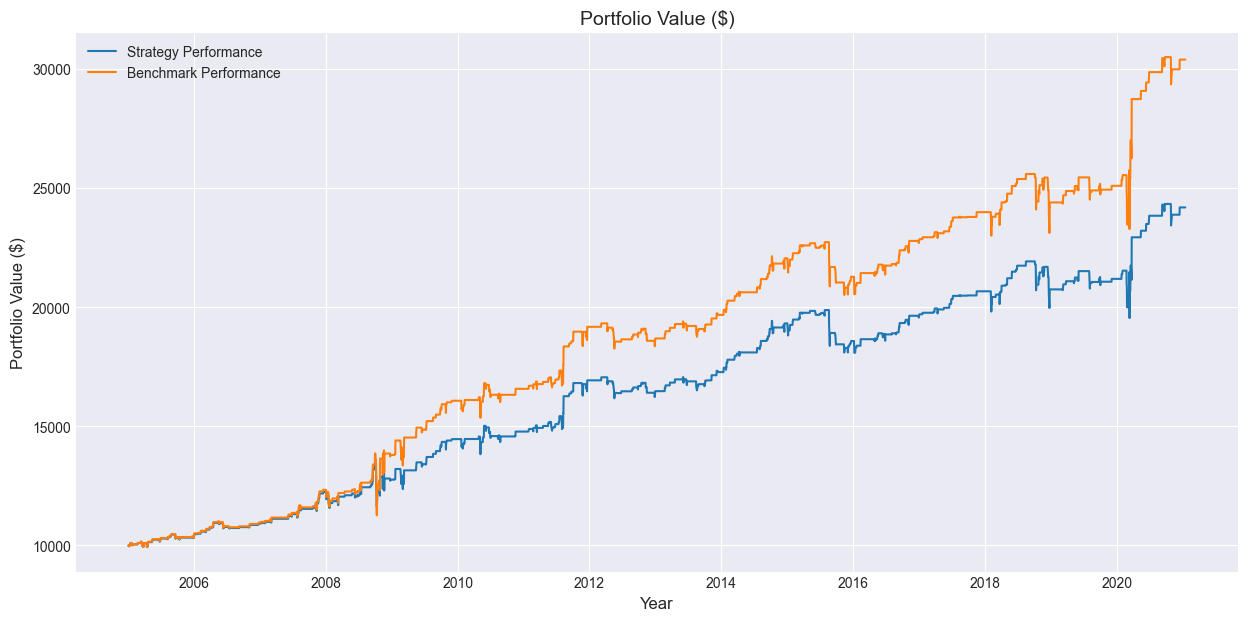

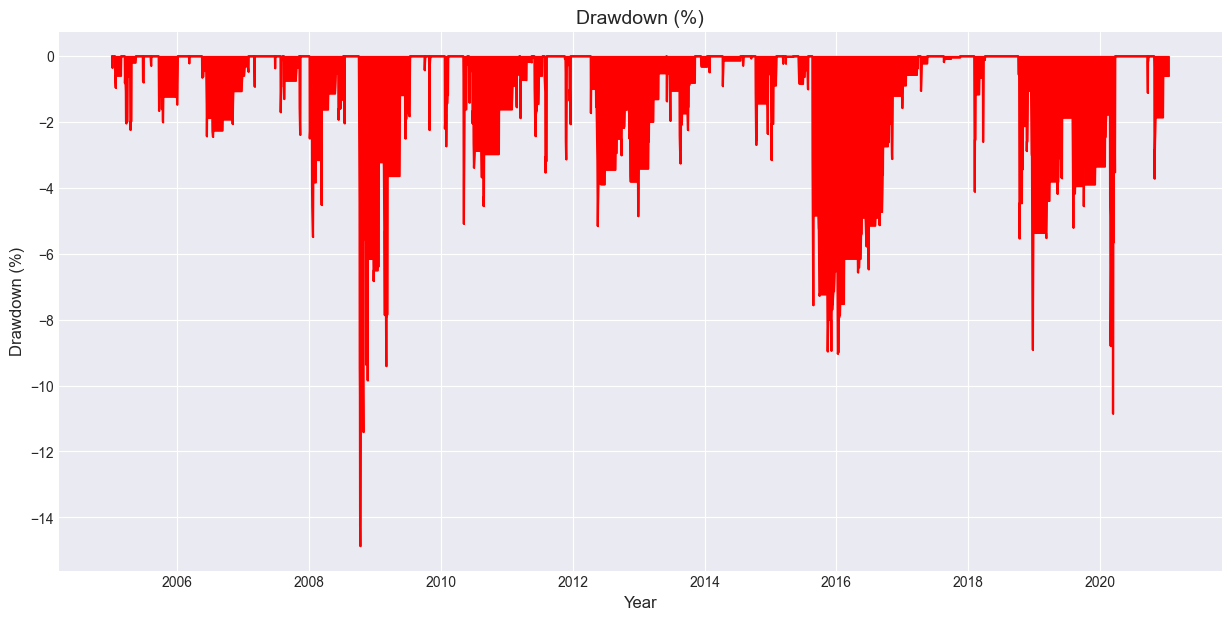

Total returns: 141.91%
Annualised returns (CAGR): 5.67%
Maximum drawdown (MDD): -14.87%
Return-to-MDD ratio: 0.38


In [5]:
# Run strategy with TIPP
strategy = run_tipp(strategy_df['returns'], m, initial_portfolio_value, floor_percent, strategy_df['signal'])

# TIPP strategy returns
strategy_with_tipp = strategy['account_history']['account_history']

# Calculate benchmark returns (Strategy without TIPP)
benchmark_returns = initial_portfolio_value * (1 + strategy_df['returns']).cumprod()

# Plot performance analysis
performance_analysis(strategy_with_tipp, benchmark_returns)

<a id='portion'></a>
## Portion of Capital
The plot shows the total wealth used in each trade which was calculated in `run_tipp`.

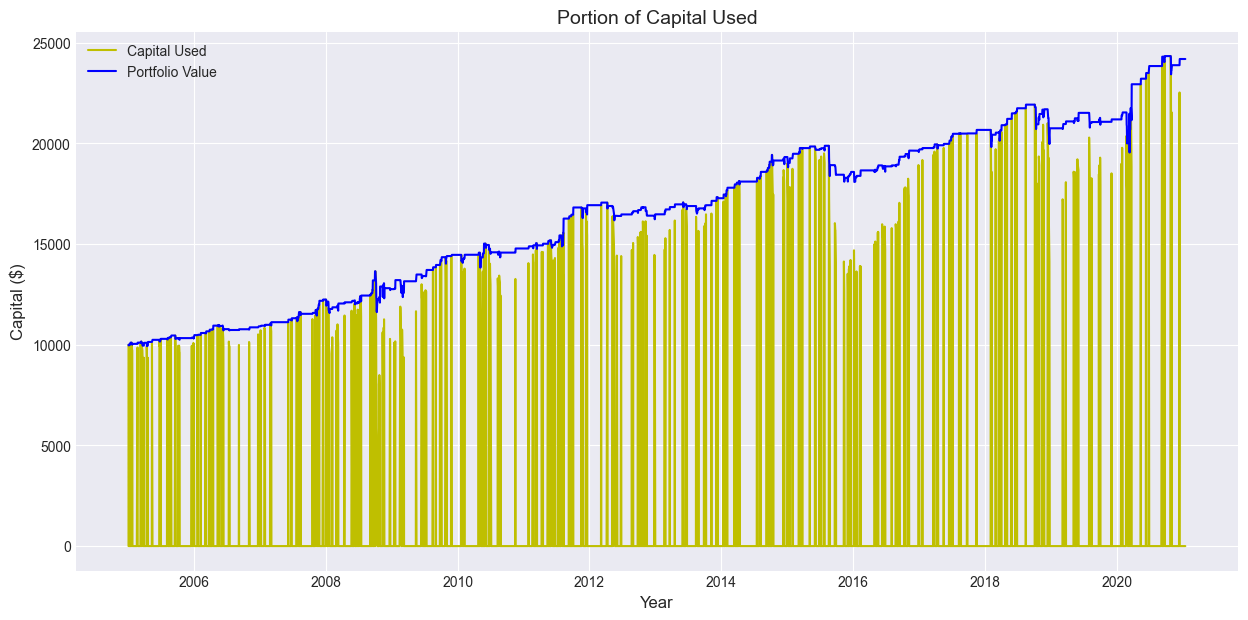

In [6]:
plot_portion_of_capital(strategy['capital_used'], strategy['account_history'])

Through the years as our account grows, we need more and more capital to deploy the strategy. We use leverage to finance this growth.

<a id='leverage'></a>
## Leverage Plot
The leverage plot shows the amount used over and above the actual account value. For simplicity, we have not considered the cost of leverage in the strategy calculations.

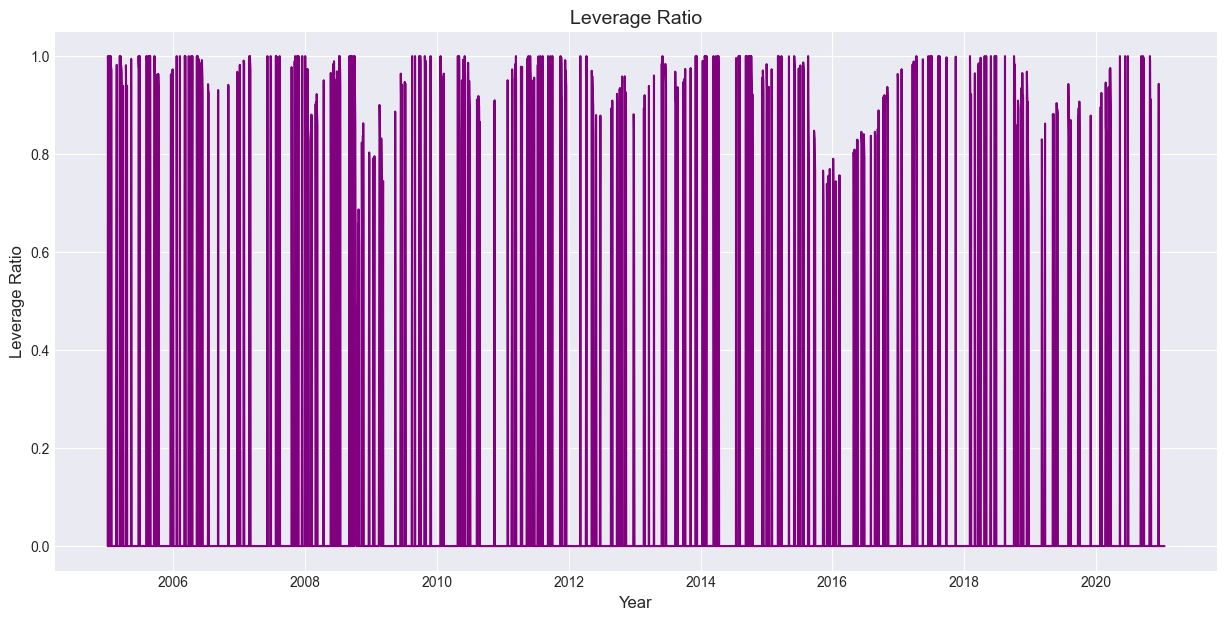

In [7]:
plot_leverage(strategy['leverage_history'])

From the TIPP logic we can see that we update the floor value based on the new account high. This keeps the leverage within a limit. As soon as the new high is created, the floor is recalculated to 75% of the new high.

## Tweak the Code
You can tweak the code in the following ways:

1. Use different multiplier values, and see how the strategy is affected.
2. Take more risk by decreasing the floor value to 65%.
3. Change the trading strategy as you wish!

In the upcoming unit, we will discuss the Kelly criterion. <br><br>